In [1]:
import numpy as np
from scipy import constants as const
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

# Climate model
from photochem.clima import AdiabatClimate

# Also set the thread count
from threadpoolctl import threadpool_limits
_ = threadpool_limits(limits=4)

# Problem: Determine the boundaries of the habitable zone

The goal is to use `AdiabatClimate` to compute the boundaries of the habitable zone for an Earth-like planet orbiting a Sun-like star. Here, we define the habitable zone as the range of distances from the star (in AU) where a planet can have condensed water on the surface for an atmosphere composed of N$_2$, H$_2$O and CO$_2$.

# Directions

First consider the inner edge of the habitable zone, then the outer edge. For the inner edge, produce figures similar to Fig. 3a and 3c in [Kopparapu et al. (2013), *ApJ*](https://doi.org/10.1088/0004-637X/765/2/131). For the outer edge make figures similar Fig. 5a and 5c of the same paper. All of these calculations can be done with the `AdiabatClimate.TOA_fluxes` function.

Kopparapu et al. (2013) introduces the quantity $S_\mathrm{eff}$, which is the fraction of the solar flux at Earth required to maintain the current climate. If `AdiabatClimate` is initialized with the solar spectrum at Earth, then we can compute $S_\mathrm{eff}$ with,

$$S_\mathrm{eff} = \frac{F_\mathrm{OLR}}{F_\mathrm{ASR}}$$

Here, $F_\mathrm{OLR}$ and $F_\mathrm{ASR}$ are the outgoing longwave and absorbed shortwave fluxes computed by the function `AdiabatClimate.TOA_fluxes`. $S_\mathrm{eff}$ can be related to the distance from the Sun, in AU with

$$d = \sqrt{\frac{1}{S_\mathrm{eff}}}$$


In [2]:
# Initialize the code
c = AdiabatClimate(
    '../6_ClimateTutorial/input/species.yaml',
    '../6_ClimateTutorial/input/settings.yaml',
    '../6_ClimateTutorial/input/Sun_now.txt',
)

## The inner edge

The inner edge is defined by the runaway greenhouse limit, or how much infrared light can be emitted from a steam atmosphere. Below, we consider a simple 1 bar N$_2$ atmosphere with an ocean reservoir of H2O (i.e., 270 bar). Following Kopparapu et al. (2013), we compute the radiative transfer of this atmosphere as a function of surface temperature:

In [3]:
P_i = np.ones(len(c.species_names))*1e-10
P_i[c.species_names.index('H2O')] = 270
P_i[c.species_names.index('N2')] = 1
P_i *= 1e6

# Follows Kopparapu et al.
c.T_trop = 200
c.rad.surface_albedo = np.ones(c.rad.surface_albedo.shape[0])*0.32

Ts = np.linspace(201,2200,100)
OLR = np.empty(Ts.shape[0])
ASR = np.empty(Ts.shape[0])
for i,T in enumerate(Ts):
    ASR_, OLR_ = c.TOA_fluxes(T, P_i)
    OLR[i] = OLR_/1.0e3
    ASR[i] = ASR_/1.0e3

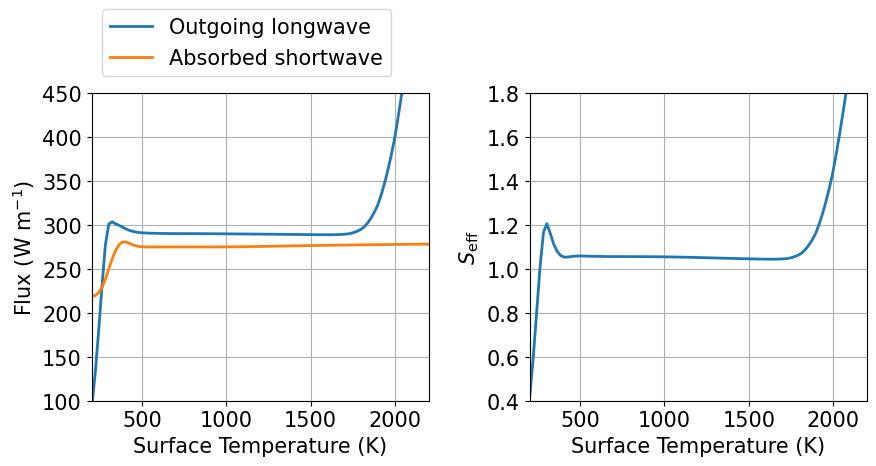

In [4]:
# Figure 3a and 3c from Kopparapu et al. (2013)

fig,axs = plt.subplots(1,2,figsize=[10,4])

ax = axs[0]
ax.plot(Ts,OLR,lw=2, label='Outgoing longwave')
ax.plot(Ts,ASR,lw=2, label='Absorbed shortwave')

ax.grid()
ax.set_ylabel('Flux (W m$^{-1}$)')
ax.set_xlabel('Surface Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
ax.set_ylim(100,450)
ax.set_xlim(200,2200)

ax = axs[1]
ax.plot(Ts,OLR/ASR,lw=2)
ax.grid()
ax.set_ylabel(r'$S_\mathrm{eff}$')
ax.set_xlabel('Surface Temperature (K)')
ax.set_ylim(0.4,1.8)
ax.set_xlim(200,2200)

plt.subplots_adjust(wspace=0.3)

plt.show()

In the plots above, you can see that the outgoing long-wave radiation plateaus for 500 K < T < 1700 K. This is the runway greenhouse limit which defines the inner edge of the habitable zone

In [5]:
ASR1, OLR1 = c.TOA_fluxes(600, P_i)
print("Runway greenhouse limit = %f W/m^2"%(OLR1/1e3))

S_eff = OLR1/ASR1
d_IHZ = np.sqrt(1/S_eff)
print('Inner edge of the habitable zone = %.2f AU'%(d_IHZ))

Runway greenhouse limit = 290.108790 W/m^2
Inner edge of the habitable zone = 0.97 AU


## The outer edge

Following Kopparapu et al. (2013) we set the surface temperature to be just above the freezing point of water, then compute radiative transfer as a function of the CO$_2$ in the atmosphere.

In [6]:
c.T_trop = 157.0 # Follows Kopparapu et al.
c.rad.surface_albedo = np.ones(c.rad.surface_albedo.shape[0])*0.2 # Follows Kopparapu et al.

# H2O and N2 atmosphere base
P_i = np.ones(len(c.species_names))*1e-10
P_i[c.species_names.index('H2O')] = 270
P_i[c.species_names.index('N2')] = 1
P_i *= 1e6

# Consider between 1 and 100 bar CO2
P_CO2s = np.logspace(0,2,100)

# Compute OLR and ASR
OLR = np.empty(P_CO2s.shape[0])
ASR = np.empty(P_CO2s.shape[0])
for i,P_CO2 in enumerate(P_CO2s):
    P_i[c.species_names.index('CO2')] = P_CO2*1e6
    ASR_, OLR_ = c.TOA_fluxes(273.2, P_i)
    OLR[i] = OLR_/1e3
    ASR[i] = ASR_/1e3
    
Seff = OLR/ASR

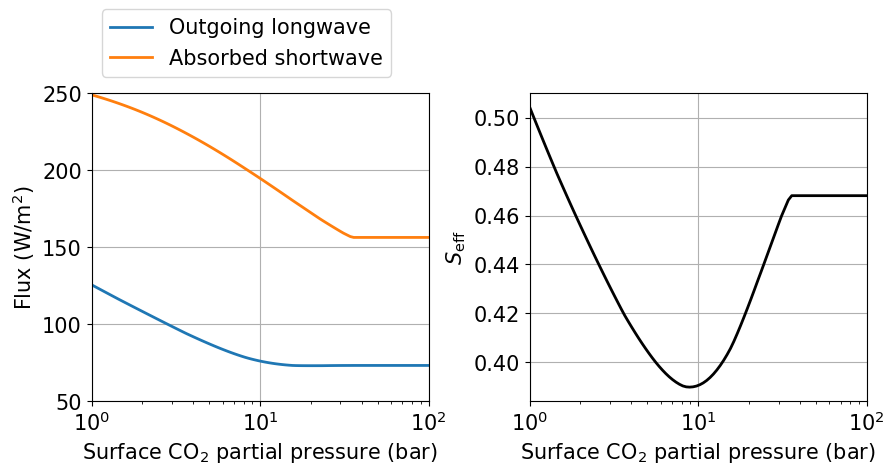

In [7]:
# Figure 5a and 5c from Kopparapu et al. (2013)

fig,axs = plt.subplots(1,2,figsize=[10,4],sharex=True)

ax = axs[0]
ax.plot(P_CO2s, OLR, lw=2, label='Outgoing longwave')
ax.plot(P_CO2s, ASR, lw=2, label='Absorbed shortwave')
ax.set_ylim(50,250)
ax.set_xlim(1e0,1e2)
ax.set_xscale('log')
ax.set_ylabel('Flux (W/m$^2$)')
ax.set_xlabel('Surface CO$_2$ partial pressure (bar)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
ax.grid()

ax = axs[1]
ax.plot(P_CO2s, Seff, lw=2, c='k')
ax.set_xscale('log')
ax.set_ylabel(r'$S_\mathrm{eff}$')
ax.set_xlabel('Surface CO$_2$ partial pressure (bar)')
ax.grid()

plt.subplots_adjust(wspace=0.3)

plt.show()

The outgoing long-wave decreases with increased CO$_2$ because of CO$_2$'s greenhouse effect. The incoming shortwave radiation also decreases because of CO$_2$ Rayleigh scattering. The minimum of $S_\mathrm{eff} \approx 0.39$ at ~9 bars CO$_2$ is the outer edge of the habitable zone which corresponds to a distance of 1.59 AU.

Kopparapu et al. (2013) finds the outer edge of the habitable zone to be instead at 1.70 AU. I am not certain, but I think our results disagree slightly because of subtle differences in the CO$_2$-CO$_2$ CIA opacities.

In [8]:
Seff_OHZ = np.min(Seff)
d_OHZ = np.sqrt(1/Seff_OHZ)
print('Outer edge of the habitable zone %.2f AU'%(d_OHZ))

Outer edge of the habitable zone 1.60 AU
